In [23]:
import pandas as pd
import numpy as np
import concurrent.futures
import itertools
from collections import defaultdict
from functools import partial
import json

# Assignment 1

In [2]:
folder = "./ml-latest-small/"

In [3]:
rating_source = pd.read_csv(folder + "ratings.csv", dtype='object')
rating_source

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
rating_source[:100]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
95,1,1445,3.0,964984112
96,1,1473,4.0,964980875
97,1,1500,4.0,964980985
98,1,1517,5.0,964981107


In [5]:
user_ratings_dict = {}
for userId, group in rating_source.groupby('userId'):
    user_ratings_dict[userId] = list(zip(group['movieId'], group['rating']))

### Definition of User Similarity


In [6]:
def get_common_movies_ratings(user1, user2, user_ratings_dict):
    user1_ratings = dict(user_ratings_dict[user1])
    user2_ratings = dict(user_ratings_dict[user2])

    common_movies = set(user1_ratings.keys()) & set(user2_ratings.keys())

    common_movies_ratings = {}
    for movie_id in common_movies:
        rating_user1 = user1_ratings.get(movie_id)
        rating_user2 = user2_ratings.get(movie_id)
        if rating_user1 is not None and rating_user2 is not None:
            common_movies_ratings[movie_id] = (rating_user1, rating_user2)    

    return common_movies_ratings

In [7]:
def get_ratings_for_user(user, user_ratings_dict):
    ratings_for_user = []

    movie_ratings_for_user = user_ratings_dict[user]

    for _, rating in movie_ratings_for_user:
        ratings_for_user.append(float(rating))
    
    ratings_for_user = np.array(ratings_for_user)
    return ratings_for_user

In [8]:
def user_similarity(user_a, user_b, user_ratings_dict):
    movie_intersection_a_b = get_common_movies_ratings(user_a, user_b, user_ratings_dict)
    if(len(movie_intersection_a_b)==0):
        return 0

    ratings_user_a, ratings_user_b = zip(*[(float(ra), float(rb)) for ra, rb in movie_intersection_a_b.values()])
    mean_rating_a = np.mean(get_ratings_for_user(user_a, user_ratings_dict))
    mean_rating_b = np.mean(get_ratings_for_user(user_b, user_ratings_dict))

    numerator = np.sum((np.array(ratings_user_a) - mean_rating_a) * (np.array(ratings_user_b) - mean_rating_b))
    denominator_a = np.sqrt(np.sum((np.array(ratings_user_a) - mean_rating_a)**2))
    denominator_b = np.sqrt(np.sum((np.array(ratings_user_b) - mean_rating_b)**2))

    similarity = numerator / (denominator_a * denominator_b) if denominator_a * denominator_b != 0 else 0

    return similarity

In [9]:
value = user_similarity("1","6", user_ratings_dict)
value

-0.30201878233102647

In [10]:
user_a = "1"
for user_b in set(rating_source['userId'].values):
    similarity = user_similarity(user_a, user_b, user_ratings_dict)
    print("User_a: {}, User_b: {} -------> Similarity: {}".format(user_a, user_b, similarity))

User_a: 1, User_b: 354 -------> Similarity: 0.008855986524654193
User_a: 1, User_b: 255 -------> Similarity: 0.31722421111944915
User_a: 1, User_b: 169 -------> Similarity: 0.25061646500949125
User_a: 1, User_b: 279 -------> Similarity: -0.01944903213716526
User_a: 1, User_b: 423 -------> Similarity: -0.3451071961803226
User_a: 1, User_b: 472 -------> Similarity: 0.9293520860459321
User_a: 1, User_b: 468 -------> Similarity: 0.050841180567491547
User_a: 1, User_b: 175 -------> Similarity: 0
User_a: 1, User_b: 220 -------> Similarity: 0.14328853147638584
User_a: 1, User_b: 246 -------> Similarity: 0.21552254075769228
User_a: 1, User_b: 486 -------> Similarity: -0.47149177364045974
User_a: 1, User_b: 514 -------> Similarity: 0.20890073323064348
User_a: 1, User_b: 245 -------> Similarity: -1.0
User_a: 1, User_b: 75 -------> Similarity: 0.41554041323434726
User_a: 1, User_b: 605 -------> Similarity: -0.16165127544524238
User_a: 1, User_b: 446 -------> Similarity: -0.21149606248476543
User_

### Method's definition for making prediction

In [11]:
def get_ratings_for_users(rating_source):
    ratings_for_user = {}

    users = rating_source[['userId', 'rating'] ]
    values = users.values

    for user, rating in values:
        if user in ratings_for_user:
            ratings_for_user[user].append(float(rating))
        else:
            ratings_for_user[user] = [float(rating)]
    
    for user in ratings_for_user:
        ratings_for_user[user] = np.array(ratings_for_user[user])
    
    return ratings_for_user

In [12]:
def get_users_ratings_for_movie(user_ratings_dict, movie_id):
    users = user_ratings_dict.keys()

    users_ratings_for_movie = [] 
    for user in users:
        movies_ratings = user_ratings_dict[user]
        for movie, rating  in movies_ratings:
            if movie == movie_id:
                users_ratings_for_movie.append((user, rating))
                break
    
    return users_ratings_for_movie

In [13]:
def making_prediction(user_a, movieId, user_ratings_dict):
    mean_rating_a = np.mean(get_ratings_for_user(user_a, user_ratings_dict))
    
    users_ratings_for_movie = get_users_ratings_for_movie(user_ratings_dict, movieId)
    numerator = 0
    denominator = 0
    
    for user_b, rating_user_b in users_ratings_for_movie:
        if(user_b != user_a):
            rating_for_movie_b = float(rating_user_b)
            mean_rating_b = np.mean(get_ratings_for_user(user_b, user_ratings_dict))
            similarity = user_similarity(user_a, user_b, user_ratings_dict)
            numerator += (similarity * (rating_for_movie_b - mean_rating_b))
            denominator += abs(similarity)

    prediction = mean_rating_a + (numerator / denominator) if abs(denominator) > 0 else 0

    return prediction   

### Top-10 most similar user and most relevant movies

#### Top k user

In [14]:
def get_top_k_user(user_a, rating_source, user_ratings_dict, k):
    results_for_similarity = {}
    users_except = rating_source[rating_source['userId'] != user_a]['userId'].unique().tolist()
    # ratings_for_users = get_ratings_for_users(rating_source)

    for user_b in users_except:
        similarity = user_similarity(user_a, user_b, user_ratings_dict)
        print("Similarity between user_a = {} and user_b = {}: {}".format(user_a, user_b, similarity))

        if similarity in results_for_similarity:
            results_for_similarity[similarity].append(user_b)
        else:
            results_for_similarity[similarity] = [user_b]
    
    results_for_similarity_ordered = sorted(results_for_similarity.items(), reverse=True)

    top_k_users = []
    for similarity, users in results_for_similarity_ordered:
        for user in users:
            if len(top_k_users) < k:
                top_k_users.append((user, similarity))
            else:
                break
    
    return top_k_users


In [15]:
result = get_top_k_user("520",rating_source, user_ratings_dict, 10)

Similarity between user_a = 520 and user_b = 1: 0.04793597191279812
Similarity between user_a = 520 and user_b = 2: -0.5060129323224231
Similarity between user_a = 520 and user_b = 3: 0
Similarity between user_a = 520 and user_b = 4: 0.334443251471257
Similarity between user_a = 520 and user_b = 5: 0.07028035144818216
Similarity between user_a = 520 and user_b = 6: 0.3510881670847032
Similarity between user_a = 520 and user_b = 7: 0.432726591574162
Similarity between user_a = 520 and user_b = 8: 0.5874419694649567
Similarity between user_a = 520 and user_b = 9: 0.30568576837603095
Similarity between user_a = 520 and user_b = 10: -0.44134546170044475
Similarity between user_a = 520 and user_b = 11: 0.049422807950960365
Similarity between user_a = 520 and user_b = 12: -0.8250912513694982
Similarity between user_a = 520 and user_b = 13: 0.711660675464719
Similarity between user_a = 520 and user_b = 14: 0.7921074607647444
Similarity between user_a = 520 and user_b = 15: 0.17389882582910673

In [17]:
result

[('44', 1.0),
 ('127', 1.0),
 ('147', 1.0),
 ('194', 1.0),
 ('207', 1.0),
 ('214', 1.0),
 ('238', 1.0),
 ('245', 1.0),
 ('333', 1.0),
 ('397', 1.0)]

#### Top k movie

In [24]:
def get_unowned_movie_ids(movies_ratings, movie_list):
    unowned_movie_ids = movie_list.copy()
    
    for movie, _ in movies_ratings:
        unowned_movie_ids.remove(movie)
    
    return unowned_movie_ids

In [25]:
def get_top_k_movie(user_a, movie_list, user_ratings_dict, k):
    results_for_prediction = {}

    unowned_movies = get_unowned_movie_ids(user_ratings_dict[user_a], movie_list)

    # ratings_for_users = get_ratings_for_users(rating_source)


    print(len(unowned_movies))
    iteration = 1

    for movieId in unowned_movies:
        prediction = making_prediction(user_a, movieId, user_ratings_dict)
        # print("{}) MovieId: {} ----> Prediction: {}".format(iteration, movieId, prediction))
        if prediction in results_for_prediction:
            results_for_prediction[prediction].append(movieId)
        else:
            results_for_prediction[prediction] = [movieId]
        iteration += 1
    
    results_for_prediction_ordered = sorted(results_for_prediction.items(), reverse=True)

    top_k_movies = []
    for prediction, movie_ids in results_for_prediction_ordered:
        for movie_id in movie_ids:
            if len(top_k_movies) < k:
                top_k_movies.append((movie_id, prediction))
            else:
                break
    
    return top_k_movies

In [26]:
movie_list = set(rating_source['movieId'])

In [27]:
movies = get_top_k_movie("3", movie_list, user_ratings_dict, 10)

9685


In [28]:
movies

[('83601', 5.89372876119864),
 ('5105', 5.860466401414677),
 ('7742', 5.860466401414677),
 ('7114', 5.860466401414677),
 ('6967', 5.860466401414677),
 ('6371', 5.711663452610528),
 ('1574', 5.522746071133168),
 ('5884', 5.522746071133168),
 ('2964', 5.522746071133168),
 ('72696', 5.444488501189532)]

### New similarity

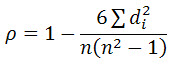
### Spearman's Correlation

In [29]:
from scipy.stats import spearmanr

In [30]:
def spearman_similarity(user_a, user_b, rating_source):
    movies_user_a = set(rating_source[rating_source['userId'] == user_a]['movieId'])
    movies_user_b = set(rating_source[rating_source['userId'] == user_b]['movieId'])

    common_movies = movies_user_a.intersection(movies_user_b)
    if not common_movies:
        return 0.0

    ratings_user_a = [float(rating_source[(rating_source['userId'] == user_a) & (rating_source['movieId'] == movie)]['rating'].values[0]) for movie in common_movies]
    ratings_user_b = [float(rating_source[(rating_source['userId'] == user_b) & (rating_source['movieId'] == movie)]['rating'].values[0]) for movie in common_movies]

    rank_user_a = [sorted(ratings_user_a).index(r) + 1 for r in ratings_user_a]
    rank_user_b = [sorted(ratings_user_b).index(r) + 1 for r in ratings_user_b]

    similarity, _ = spearmanr(rank_user_a, rank_user_b)
    
    return similarity

In [31]:
result = spearman_similarity("1", "6", rating_source)

In [32]:
result

-0.31111362632773987

# Assignment 2

In [80]:
users = ["474", "599", "414"]

In [34]:
movie_list = set(rating_source['movieId'])

In [35]:
def get_unwatched_movies(user_id, rating_source, movie_list):
    watched_movies = set(rating_source[rating_source['userId'] == user_id]['movieId'])
    unwatched_movies = list(set(movie_list) - watched_movies)
    return set(unwatched_movies)

In [36]:
def get_intersection_movies_for_users(user_ids, movie_list, rating_source):
    movies_sets = [get_unwatched_movies(user, rating_source, movie_list) for user in user_ids]
    union_movies = set.intersection(*movies_sets)
    return union_movies

In [37]:
def get_rating_if_user_contains_movie(user, movieId, user_ratings_dict):
    movies_ratings = user_ratings_dict[user]

    for movie, rating in movies_ratings:
        if movie == movieId:
            return float(rating)
    
    return None


In [38]:
def average_aggregation(users, movie_list, user_ratings_dict, k, rating_source):
    movies = get_intersection_movies_for_users(users, movie_list, rating_source)
    print(len(movies))
    
    iteration = 1
    movies_to_average_rating = {}
    for movie in movies: 
        sum_for_movie = 0
        for user in users:
            rating_user = get_rating_if_user_contains_movie(user, movie, user_ratings_dict)
            if rating_user == None:
                prediction_for_movie = making_prediction(user, movie, user_ratings_dict)
                sum_for_movie += prediction_for_movie
            else:
                sum_for_movie += rating_user
        
        movies_to_average_rating[movie] = (sum_for_movie/len(users))
        print("{}) Movie: {} ----> Average Rating: {}".format(iteration, movie, movies_to_average_rating.get(movie)))
        iteration += 1
    
    movies_to_average_rating_ordered = dict(sorted(movies_to_average_rating.items(), key=lambda item: item[1], reverse=True))

    top_k_movies_recommend = dict(list(movies_to_average_rating_ordered.items())[:k])

    return top_k_movies_recommend

In [39]:
def least_misery_aggregation(users, movie_list, user_ratings_dict, k, rating_source):
    movies = get_intersection_movies_for_users(users, movie_list, rating_source)
    movies_to_min_rating = {}

    print(len(movies))
    iteration = 1
    for movie in movies: 
        ratings_for_movie = []
        for user in users:
            rating_user = get_rating_if_user_contains_movie(user, movie, user_ratings_dict)
            if rating_user == None:
                prediction_for_movie = making_prediction(user, movie, user_ratings_dict)
                ratings_for_movie.append(prediction_for_movie)
            else:
                ratings_for_movie.append(rating_user)
        
        movies_to_min_rating[movie] = min(ratings_for_movie)
        print("{}) Movie: {} ----> Min Rating: {}".format(iteration, movie, movies_to_min_rating.get(movie)))
        iteration += 1
    
    movies_to_min_rating_ordered = dict(sorted(movies_to_min_rating.items(), key=lambda item: item[1], reverse=True))

    top_k_movies_recommend = dict(list(movies_to_min_rating_ordered.items())[:k])

    return top_k_movies_recommend 

In [40]:
result = average_aggregation(users, movie_list, user_ratings_dict, 10, rating_source)

5017
1) Movie: 117881 ----> Average Rating: 3.446968915164053
2) Movie: 169 ----> Average Rating: 1.9820097494514244
3) Movie: 7065 ----> Average Rating: 1.7687680367483327
4) Movie: 26078 ----> Average Rating: 3.6815551766466577
5) Movie: 59220 ----> Average Rating: 3.410590975363307
6) Movie: 50445 ----> Average Rating: 2.224536490021425
7) Movie: 53355 ----> Average Rating: 1.6172941070664386
8) Movie: 104908 ----> Average Rating: 2.761617482047894
9) Movie: 5269 ----> Average Rating: 3.4869220309544517
10) Movie: 4792 ----> Average Rating: 3.1939214479948084
11) Movie: 2820 ----> Average Rating: 3.1443211340934654
12) Movie: 70687 ----> Average Rating: 2.742117865004399
13) Movie: 4953 ----> Average Rating: 2.4983495701124228
14) Movie: 33558 ----> Average Rating: 3.124145695496974
15) Movie: 2695 ----> Average Rating: 1.284861674634006
16) Movie: 2159 ----> Average Rating: 3.640595159075245
17) Movie: 56837 ----> Average Rating: 2.2321073936354505
18) Movie: 4733 ----> Average Rat

In [48]:
result

[('5105', 6.440276126849194),
 ('7742', 6.440276126849194),
 ('7114', 6.440276126849194),
 ('6967', 6.440276126849194),
 ('3604', 5.988680134304927),
 ('97024', 5.7942785899033815),
 ('173307', 5.7764295089617494),
 ('160872', 5.7764295089617494),
 ('86068', 5.7764295089617494),
 ('138186', 5.7764295089617494)]

In [56]:
result = least_misery_aggregation(users, movie_list, user_ratings_dict, 10, rating_source)

5017
1) Movie: 111375 ----> Min Rating: 1.802266758621379
2) Movie: 6886 ----> Min Rating: 2.760992771632658
3) Movie: 65359 ----> Min Rating: 2.4316428005361206
4) Movie: 74754 ----> Min Rating: 2.6029653085705333
5) Movie: 1453 ----> Min Rating: 0.854013336480727
6) Movie: 4756 ----> Min Rating: 1.078682114208189
7) Movie: 3048 ----> Min Rating: 1.6258523423028917
8) Movie: 4325 ----> Min Rating: 2.525706550050416
9) Movie: 92475 ----> Min Rating: 3.8254066477009787
10) Movie: 189713 ----> Min Rating: 2.4923629501428364
11) Movie: 83601 ----> Min Rating: -0.8157812849460795
12) Movie: 2661 ----> Min Rating: 1.8662840236420335
13) Movie: 5882 ----> Min Rating: 1.9428357532573999
14) Movie: 101884 ----> Min Rating: 1.2946787957199322
15) Movie: 1337 ----> Min Rating: 3.7463978664420816
16) Movie: 138036 ----> Min Rating: 2.736682184759381
17) Movie: 121715 ----> Min Rating: 2.802266758621379
18) Movie: 2905 ----> Min Rating: 3.555277841061126
19) Movie: 25771 ----> Min Rating: 4.034547

In [58]:
result

{'159441': 11.447748742400682,
 '165947': 8.416539224421216,
 '160567': 6.396320265488315,
 '7067': 6.154319498668819,
 '6967': 6.066619005872367,
 '7114': 6.066619005872367,
 '5105': 6.066619005872367,
 '7742': 6.066619005872367,
 '946': 5.825524982000262,
 '3604': 5.6150230133280985}

### Method that considered the disagreements between the users in a group


In [67]:
def get_recommendation_for_user(user, movies, user_ratings_dict):
    movie_for_rating = []
    
    for movie in movies:
        rating_user = get_rating_if_user_contains_movie(user, movie, user_ratings_dict)
        if rating_user == None:
            prediction = making_prediction(user, movie, user_ratings_dict)
            movie_for_rating.append((movie, prediction))
        else:
            movie_for_rating.append((movie, rating_user))
    
    movie_for_rating_ordered = dict(sorted(movie_for_rating, key=lambda item: item[1], reverse=True))
    
    return list(movie_for_rating_ordered.keys())

In [72]:
movies = get_intersection_movies_for_users(users, movie_list, rating_source)

In [69]:
def kendall_tau_distance(recommend_movies_a, recommend_movies_b):
    distance = 0
    recommend_movies_a_copy = recommend_movies_a.copy()
    recommend_movies_b_copy = recommend_movies_b.copy()
    for i in range(len(recommend_movies_a_copy)):
        movie = recommend_movies_a_copy[i]
        for j in range(len(recommend_movies_b_copy)):
            if i == j and recommend_movies_b_copy[j] != movie:
                index = recommend_movies_b_copy.index(movie) 
                different_movie = recommend_movies_b_copy[j]
                recommend_movies_b_copy[j] = movie
                recommend_movies_b_copy[index] = different_movie
                distance += 1
    
    return distance

In [70]:
def divide_dict_values(d, divisor):
    for key in d:
        d[key] = 1-(d[key]/divisor)
    return d

In [81]:
def average_weighted_aggregation(users, movie_list, user_ratings_dict, k):
    movies = get_intersection_movies_for_users(users, movie_list, rating_source)

    recommend_for_user = {user: list(get_recommendation_for_user(user, movies, user_ratings_dict)) for user in users}
    total_distance_sum = 0

    user_distances = {}
    for i in range(len(users)):
        for j in range(i+1, len(users)):
            user_a = users[i]
            user_b = users[j]
            tau = kendall_tau_distance(recommend_for_user[user_a], recommend_for_user[user_b])
            user_distances[(user_a, user_b)] = tau
            total_distance_sum += tau
    
    user_to_weight = {}
    for (user_a, user_b), distance in user_distances.items():
        user_to_weight.setdefault(user_a, 0)
        user_to_weight.setdefault(user_b, 0)
        user_to_weight[user_a] += distance
        user_to_weight[user_b] += distance
    
    user_to_weight = divide_dict_values(user_to_weight, total_distance_sum)
    
    weighted_movie_averages = {}
    for movie in movies:
        weighted_sum = 0
        total_weight = 0
        for user in users:
            weight = user_to_weight.get(user, 0)
            rating_user = get_rating_if_user_contains_movie(user, movie, user_ratings_dict)
            if rating_user != None:
                rating = rating_user
            else:
                rating = making_prediction(user, movie, user_ratings_dict) 
            weighted_sum += rating * weight
            total_weight += weight
        weighted_average = weighted_sum / total_weight if total_weight != 0 else 0
        weighted_movie_averages[movie] = weighted_average
        print("MovieId: {}  ---->  Weighted Average Rating: {}".format(movie, weighted_average))

    top_k_recommendations = sorted(weighted_movie_averages.items(), key=lambda x: x[1], reverse=True)[:k]

    return top_k_recommendations

In [82]:
result = average_weighted_aggregation(users, movie_list, user_ratings_dict, 10)

MovieId: 117881  ---->  Weighted Average Rating: 3.445118380715317
MovieId: 169  ---->  Weighted Average Rating: 1.980024554001674
MovieId: 7065  ---->  Weighted Average Rating: 1.767052246766584
MovieId: 26078  ---->  Weighted Average Rating: 3.6798393866649084
MovieId: 59220  ---->  Weighted Average Rating: 3.408875185381558
MovieId: 50445  ---->  Weighted Average Rating: 2.2228006806942995
MovieId: 53355  ---->  Weighted Average Rating: 1.6155783170846898
MovieId: 104908  ---->  Weighted Average Rating: 2.7592610311627066
MovieId: 5269  ---->  Weighted Average Rating: 3.485206240972703
MovieId: 4792  ---->  Weighted Average Rating: 3.192436259266829
MovieId: 2820  ---->  Weighted Average Rating: 3.1426053441117165
MovieId: 70687  ---->  Weighted Average Rating: 2.7401945298960375
MovieId: 4953  ---->  Weighted Average Rating: 2.496633780130674
MovieId: 33558  ---->  Weighted Average Rating: 3.122429905515226
MovieId: 2695  ---->  Weighted Average Rating: 1.2831458846522572
MovieId: 

In [83]:
result

[('5105', 6.5671743096289585),
 ('7742', 6.5671743096289585),
 ('7114', 6.5671743096289585),
 ('6967', 6.5671743096289585),
 ('3604', 6.11557831708469),
 ('97024', 5.921176772683145),
 ('173307', 5.903327691741513),
 ('160872', 5.903327691741513),
 ('86068', 5.903327691741513),
 ('138186', 5.903327691741513)]

# Assignment 3

### GR: A sequence of μ group recommendations (Gr1,…,Grμ)
### • pj(ui,dz): preference score of user ui for item dz at iteration j 
### • gpj(G,dz): preference score of item dz for the group G as a whole, as 
### estimated by the group recommender at iteration j 

In [84]:
users = ["474", "599", "414"]

In [64]:
def weighted_average_aggregation(users, users_weight, user_ratings_dict, k, alfa, rating_source):
    movies = get_intersection_movies_for_users(users, movie_list, rating_source)
    
    movies_to_rating = {}
    iteration = 1
    for movie in movies: 
        sum_for_movie = 0
        total_weight = 0

        for user in users:
            rating_user = get_rating_if_user_contains_movie(user, movie, user_ratings_dict)
            if rating_user == None:
                prediction_for_movie = making_prediction(user, movie, user_ratings_dict)
                rating_user = prediction_for_movie

            weight = (1-users_weight[user])
            sum_for_movie += weight * rating_user
            total_weight += weight

        movies_to_rating[movie] = sum_for_movie/total_weight
        # print("{}) Movie: {} ----> Average Rating: {}".format(iteration, movie, movies_to_rating.get(movie)))
        iteration += 1
    
    movies_to_rating_ordered = dict(sorted(movies_to_rating.items(), key=lambda item: item[1], reverse=True))

    top_k_movies_recommend = dict(list(movies_to_rating_ordered.items())[:k])

    return top_k_movies_recommend

In [86]:
def get_group_list_sat(user, recommend_j, user_ratings_dict):
    total_preference_score = 0

    for movie in recommend_j.keys():
        rating_user = making_prediction(user, movie, user_ratings_dict)
        total_preference_score += rating_user

    return total_preference_score 

In [87]:
def get_user_list_sat(top_k_movie):
    total_preference_score = 0

    for _, rating in top_k_movie:
        total_preference_score += rating
    
    return total_preference_score

In [89]:
def set_users_weight(satisfaction_for_user):
    users_weight = {}
    total_satisfaction = 0.0
    for _, satisfaction in satisfaction_for_user.items():
        total_satisfaction += satisfaction
    
    for user, satisfaction in satisfaction_for_user.items():
        users_weight[user] = 1 - (satisfaction/total_satisfaction)

    return users_weight

In [91]:
def sequential_average_weighted_aggregation(users, iterations, k, user_ratings_dict, rating_source, movie_list):
    satisfaction_for_user = {}
    for user in users:
        satisfaction_for_user[user] = 0.5
    
    top_k_movie_for_user = {}
    for user in users:
        top_k_movie_for_user[user] = get_top_k_movie(user, movie_list, user_ratings_dict, k)
        print("User: {}  |  Top {} movie: {}".format(user, k, top_k_movie_for_user[user]))

    satisfactions_for_iteration = {}
    for i in range(1, (iterations + 1)):
        users_weight = set_users_weight(satisfaction_for_user)

        print("Inizio iterazione {}".format(i))
        recommend = weighted_average_aggregation(users, users_weight, user_ratings_dict, k, 0.5, rating_source)

        satisfactions_for_iteration[i] = []
        for user in users:
            group_list_sat = get_group_list_sat(user, recommend, user_ratings_dict)
            user_list_sat = get_user_list_sat(top_k_movie_for_user[user])
            satisfaction = group_list_sat/user_list_sat
            
            satisfaction_for_user[user] = satisfaction
            satisfactions_for_iteration.get(i).append((user, satisfaction, users_weight[user]))
            print("User: {}  |  Satisfaction: {}".format(user, satisfaction))

    return satisfactions_for_iteration


In [115]:
satisfaction_for_iteration = sequential_average_weighted_aggregation(users, 3, 10, user_ratings_dict, rating_source, movie_list)

7616
1) MovieId: 102852 ----> Prediction: 3.7569063163811176
2) MovieId: 105593 ----> Prediction: 3.775353190799935
3) MovieId: 4876 ----> Prediction: 2.4524167886108907
4) MovieId: 2896 ----> Prediction: 3.035319993099879
5) MovieId: 85367 ----> Prediction: 3.2453193141554775
6) MovieId: 6014 ----> Prediction: 2.5243505708543155
7) MovieId: 710 ----> Prediction: 2.88910062328875
8) MovieId: 8959 ----> Prediction: 2.5204303502238328
9) MovieId: 1609 ----> Prediction: 2.9325215335585337
10) MovieId: 183227 ----> Prediction: 3.5591730750024966
11) MovieId: 4865 ----> Prediction: 3.596943624365985
12) MovieId: 4086 ----> Prediction: 3.269828313179654
13) MovieId: 56145 ----> Prediction: 3.4081414462346467
14) MovieId: 1015 ----> Prediction: 2.8945476978645255
15) MovieId: 6705 ----> Prediction: 3.233315331095217
16) MovieId: 3940 ----> Prediction: 1.8364563567362429
17) MovieId: 142961 ----> Prediction: 3.11831119544592
18) MovieId: 7411 ----> Prediction: 1.1300975559625486
19) MovieId: 1

In [91]:
def get_overall_user_satisfaction(user, satisfaction_for_iteration):
    overall_satisfaction = 0

    for _, satisfactions_users in satisfaction_for_iteration.items():
        for u, satisfaction, _ in satisfactions_users:
            if u == user:
                overall_satisfaction += satisfaction
                break
    
    return overall_satisfaction/len(satisfaction_for_iteration)

In [83]:
def get_group_satisfaction_and_disagreement(users, satisfaction_for_iteration):
    overall_group_satisfacion = 0
    group_disagreement = []

    for user in users:
        overall_user_satisfaction = get_overall_user_satisfaction(user, satisfaction_for_iteration)
        overall_group_satisfacion += overall_user_satisfaction
        group_disagreement.append(overall_user_satisfaction)

    return (overall_group_satisfacion/(len(users))), (max(group_disagreement) - min(group_disagreement))

### Experiments

In [95]:
users_set = [["474", "599", "414"], ["45", "435", "572"], ["127", "256", "12"], ["549", "478", "82"], 
                ["601", "331", "393"], ["589", "200", "348"], ["8", "198", "406"], ["96", "441", "459"],
                ["28", "51", "585"], ["415", "587", "106"]]

In [96]:
def write_to_file(satisfaction_for_iteration, group_satisfaction, disagreement):  
    with open("Experiments_average_aggregation_method.txt", 'a') as f:
            for iteration, users_satisfactions in satisfaction_for_iteration.items():
                f.write(f"Iteration {iteration}\n")
                for user, satisfaction, weight in users_satisfactions:
                    f.write
                    f.write(f"User: {user}  ----> Satisfaction: {satisfaction}, Weight: {weight}\n")
            f.write("\nGroup Satisfaction: {}\nDisagreement: {}\n".format(group_satisfaction, disagreement))
            f.write("----------------------------\n")

In [97]:
def execute_experiments():
    for users in users_set:
        print(users)
        satisfaction_for_iteration = sequential_average_weighted_aggregation(users, 3, 10, user_ratings_dict, rating_source, movie_list)
        group_satisfaction, disagreement = get_group_satisfaction_and_disagreement(users, satisfaction_for_iteration)
        write_to_file(satisfaction_for_iteration, group_satisfaction, disagreement)
        

In [98]:
execute_experiments()

['474', '599', '414']
7616
User: 474  |  Top 10 movie: [('5105', 6.823525322253484), ('6967', 6.823525322253484), ('7742', 6.823525322253484), ('7114', 6.823525322253484), ('168712', 6.495110202890089), ('3604', 6.371929329709216), ('97024', 6.177527785307671), ('173307', 6.15967870436604), ('86068', 6.15967870436604), ('138186', 6.15967870436604)]
7246
User: 599  |  Top 10 movie: [('5105', 6.066619005872367), ('6967', 6.066619005872367), ('7742', 6.066619005872367), ('7114', 6.066619005872367), ('3604', 5.6150230133280985), ('97024', 5.420621468926553), ('173307', 5.402772387984923), ('86068', 5.402772387984923), ('138186', 5.402772387984923), ('160872', 5.402772387984923)]
7026
User: 414  |  Top 10 movie: [('5105', 6.816525970706271), ('6967', 6.816525970706271), ('7742', 6.816525970706271), ('7114', 6.816525970706271), ('3604', 6.364929978162001), ('97024', 6.170528433760458), ('173307', 6.152679352818826), ('86068', 6.152679352818826), ('138186', 6.152679352818826), ('160872', 6.15